In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import os
import glob

In [48]:
# Задачи для рефакторинга:
#  - Использовать фрейм os для нормального импорта. Done! 
#  - Нормально оформить заголовки и комменты. In process
# Прогресс - 90% (косметический и кодовый рефакторинг)

In [24]:
path = '/home/zachary/data_analysis_dir/data_analysis_env/files_by_yandex_practicum/'
all_files = glob.glob(path + "/*.csv")
all_files

['/home/zachary/data_analysis_dir/data_analysis_env/files_by_yandex_practicum/calls.csv',
 '/home/zachary/data_analysis_dir/data_analysis_env/files_by_yandex_practicum/internet.csv',
 '/home/zachary/data_analysis_dir/data_analysis_env/files_by_yandex_practicum/users.csv',
 '/home/zachary/data_analysis_dir/data_analysis_env/files_by_yandex_practicum/tariffs.csv',
 '/home/zachary/data_analysis_dir/data_analysis_env/files_by_yandex_practicum/messages.csv']

In [25]:
calls, internet, users, tariffs, messages = [pd.read_csv(i) for i in all_files]

## Предобработка данных и первичный анализ:

In [26]:
# Меняем типы данных в подозрительных датасетах
calls['call_date'] = calls['call_date'].apply(pd.to_datetime)
internet['session_date'] = internet['session_date'].apply(pd.to_datetime)
messages['message_date'] = messages['message_date'].apply(pd.to_datetime)

In [27]:
# Посчитайте для каждого пользователя:
# 1. количество сделанных звонков и израсходованных минут разговора по месяцам;
# 2. количество отправленных сообщений по месяцам;
# 3. объем израсходованного интернет-трафика по месяцам;
# 4. помесячную выручку с каждого пользователя 
# (вычтите бесплатный лимит из суммарного количества звонков,
# сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, 
# соответствующую тарифному плану).

In [28]:
# Создание столбцов с месяцами в каждом датасете
calls['month'] = calls['call_date'].dt.strftime('%b')
internet['month'] = internet['session_date'].dt.strftime('%b')
messages['month'] = messages['message_date'].dt.strftime('%b')

In [29]:
# 1. количество сделанных звонков и израсходованных минут разговора по месяцам
calls_filtred = calls.groupby(by=['user_id', 'month'], as_index=False).aggregate({'duration': ['sum', 'count']})
calls_filtred['duration'] = calls_filtred['duration'].apply(np.ceil)
calls_filtred.head()

user_id month duration      
                     sum count
0    1000   Aug    390.0  52.0
1    1000   Dec    313.0  46.0
2    1000   Jul    319.0  47.0
3    1000   Jun    159.0  43.0
4    1000   May    151.0  22.0

In [30]:
# 2. количество отправленных сообщений по месяцам;
messages_filtered = messages.groupby(by=['user_id', 'month'], as_index=False).aggregate(number_of_messages=('id', 'count'))
messages_filtered.head()

,user_id,month,number_of_messages
0,1000,Aug,81
1,1000,Dec,70
2,1000,Jul,75
3,1000,Jun,60
4,1000,May,22


In [31]:
# 3. объем израсходованного интернет-трафика по месяцам;
internet_filtered = internet.groupby(by=['user_id', 'month'], as_index=False).aggregate({'mb_used': 'sum'})
internet_filtered.head()

,user_id,month,mb_used
0,1000,Aug,14055.93
1,1000,Dec,9817.61
2,1000,Jul,14003.64
3,1000,Jun,23233.77
4,1000,May,2253.49


In [32]:
# Дабы избежать путаницы, смерджим тарифы к каждому из трех датасетов для дальнейших рассчетов
calls_filtred = pd.merge(calls_filtred, users[['user_id', 'tariff']], on='user_id')
messages_filtered = pd.merge(messages_filtered, users[['user_id', 'tariff']], on='user_id')
internet_filtered = pd.merge(internet_filtered, users[['user_id', 'tariff']], on='user_id')

/tmp/ipykernel_10208/3181021180.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  calls_filtred = pd.merge(calls_filtred, users[['user_id', 'tariff']], on='user_id')


In [33]:
# Изменим имена столбцов для лучшей читабельности (?)
calls_filtred.set_axis(['user_id', 'drop', 'month', 'call_duration_sum', 'call_duration_count', 'tariff'],
                       axis='columns', 
                       inplace=True)
calls_filtred.head()

,user_id,drop,month,call_duration_sum,call_duration_count,tariff
0,1000,1000,Aug,390.0,52.0,ultra
1,1000,1000,Dec,313.0,46.0,ultra
2,1000,1000,Jul,319.0,47.0,ultra
3,1000,1000,Jun,159.0,43.0,ultra
4,1000,1000,May,151.0,22.0,ultra


In [34]:
def count_calls(row):

    tariff = row['tariff']
    duration = row['call_duration_sum']
    
    if tariff == 'ultra':
        if duration > 1950:
            return duration - 1950
        else:
            return 0
    else: 
        if duration > 550:
            return (duration - 500) * 3
        else:
            return 0

def count_messages(row):
    
    tariff = row['tariff']
    quantity_of_messages = row['number_of_messages']
    
    if tariff == 'ultra':
        if quantity_of_messages > 1000:
            return quantity_of_messages - 1000 
        else:
            return 0
    else:
        if quantity_of_messages > 50:
            return (quantity_of_messages - 50) * 3
        else: 
            return 0

def count_internet(row):
    
    tariff = row['tariff']
    sum_mb_per_month = row['mb_used']
    
    if tariff == 'ultra':
        if sum_mb_per_month > 30720:
            return np.ceil((sum_mb_per_month - 30720) / 1024) * 150
        else: 
            return 0
    else:
        if sum_mb_per_month > 15360:
            return np.ceil((sum_mb_per_month - 15360) / 1024) * 200
        else: 
            return 0    

In [35]:
calls_filtred['calls_over_tariff'] = calls_filtred.apply(count_calls, axis=1)

In [36]:
messages_filtered['messages_over_tariff'] = messages_filtered.apply(count_messages, axis=1)

In [37]:
internet_filtered['internet_over_tariff'] = internet_filtered.apply(count_internet, axis=1)

In [38]:
df_merged = internet_filtered.merge(calls_filtred) \
                             .merge(messages_filtered)
df_merged.head()

,user_id,month,mb_used,tariff,internet_over_tariff,drop,call_duration_sum,call_duration_count,calls_over_tariff,number_of_messages,messages_over_tariff
0,1000,Aug,14055.93,ultra,0.0,1000,390.0,52.0,0.0,81,0
1,1000,Dec,9817.61,ultra,0.0,1000,313.0,46.0,0.0,70,0
2,1000,Jul,14003.64,ultra,0.0,1000,319.0,47.0,0.0,75,0
3,1000,Jun,23233.77,ultra,0.0,1000,159.0,43.0,0.0,60,0
4,1000,May,2253.49,ultra,0.0,1000,151.0,22.0,0.0,22,0


In [39]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [40]:
# 4. Помесячная выручка
def total_revenue(row):
    """Суммировать отклонения от стоимости тарифа и сам тариф, 
    таким образом получим помесячную выручку для каждого пользователя"""
    tariff = row['tariff']
    calls = row['calls_over_tariff']
    messages = row['messages_over_tariff']
    internet = row['internet_over_tariff']
    
    if tariff == 'ultra':
        return calls + messages + internet + 1950
    else:
        return calls + messages + internet + 550

In [41]:
df_merged['attempt_of_revenue'] = df_merged.apply(total_revenue, axis=1)
# Избавимся от дубликатов столбцов ?
df_merged.drop(columns='drop', inplace = True)

In [42]:
df_merged.head()

,user_id,month,mb_used,tariff,internet_over_tariff,call_duration_sum,call_duration_count,calls_over_tariff,number_of_messages,messages_over_tariff,attempt_of_revenue
0,1000,Aug,14055.93,ultra,0.0,390.0,52.0,0.0,81,0,1950.0
1,1000,Dec,9817.61,ultra,0.0,313.0,46.0,0.0,70,0,1950.0
2,1000,Jul,14003.64,ultra,0.0,319.0,47.0,0.0,75,0,1950.0
3,1000,Jun,23233.77,ultra,0.0,159.0,43.0,0.0,60,0,1950.0
4,1000,May,2253.49,ultra,0.0,151.0,22.0,0.0,22,0,1950.0


## Анализ обработанных данных:

In [43]:
# Сколько минут разговора, сколько сообщений и какой объём интернет-трафика 
# требуется пользователям каждого тарифа в месяц?
# Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [44]:
# - Для тарифа smart:
average_per_month_smart = df_merged[df_merged['tariff'] == 'smart'] \
                          .groupby(by='user_id') \
                          .aggregate(average_of_calls=('call_duration_count', 'mean'), 
                                      average_of_messages=('number_of_messages', 'mean'),
                                      average_of_mb_used=('mb_used', 'mean'),
                                      revenue=('attempt_of_revenue', 'mean'))
average_per_month_smart.head()

,average_of_calls,average_of_messages,average_of_mb_used,revenue
user_id,,,,
1002,31.0,10.0,16576.645714,1035.714286
1005,74.0,46.0,8307.275833,738.500000
1007,68.0,25.0,14625.074444,852.111111
1008,52.0,56.0,13217.140000,568.000000
1009,29.0,11.0,17741.121000,1310.000000


/home/zachary/data_analysis_dir/data_analysis_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zachary/data_analysis_dir/data_analysis_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zachary/data_analysis_dir/data_analysis_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

ValueError: num must be 1 <= num <= 6, not 7

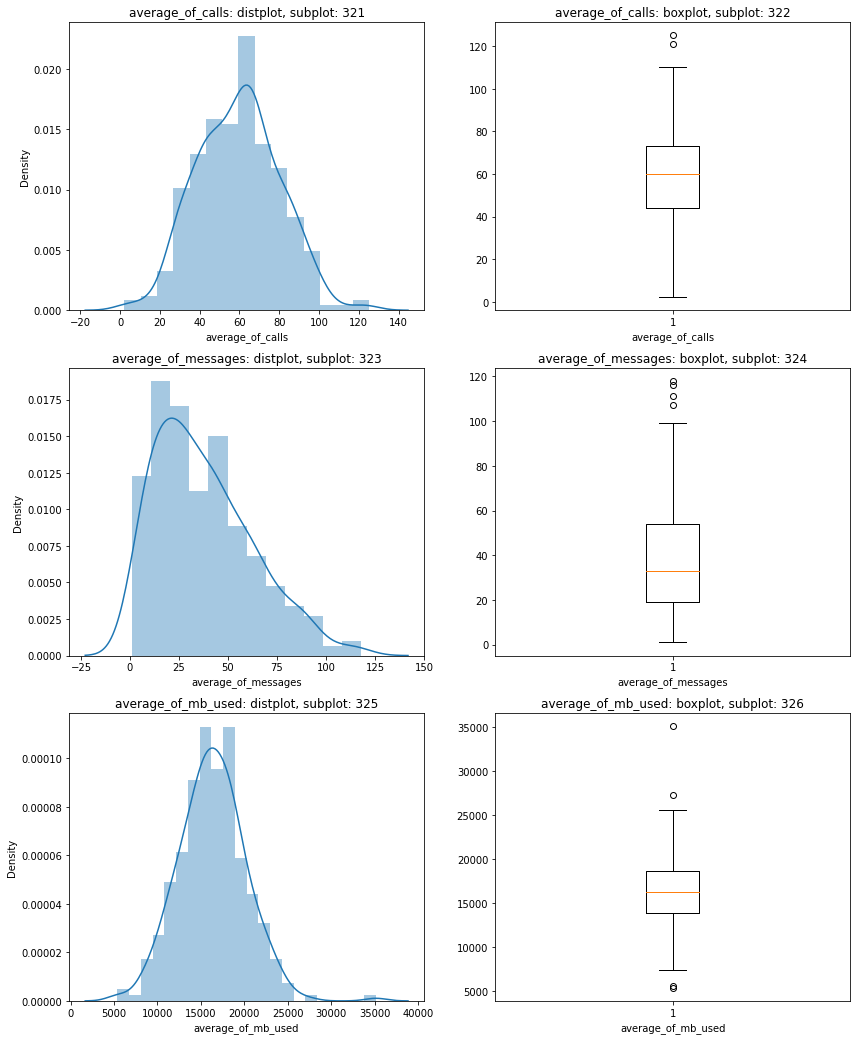

In [45]:
# Построим гистограммы и найдем меры изменчивости(?)
fig = plt.figure(figsize=(14,18))

a, b, c = 3, 2, 1
for name in average_per_month_smart.columns:
    plt.subplot(a, b, c)
    plt.title(f"{name}: distplot, subplot: {a}{b}{c}")
    plt.xlabel(name)
    sns.distplot(average_per_month_smart[name])
    c = c + 1
    
    plt.subplot(a, b, c)
    plt.title(f"{name}: boxplot, subplot: {a}{b}{c}")
    plt.xlabel(name)
    plt.boxplot(average_per_month_smart[name])
    c = c + 1
    
plt.show()

In [ ]:
# - В целом, наши пользователи тарифа смарт делают около 60 звонков в месяц. 
# - По количеству сообщений не все так однозначно, т.к. имеется скошенность вправо и явные выбросы, 
# поэтому стоит доверять медиане - 33 сообщениям, как устойчивой к выбросам величине.
# - Трафик также, как и звонки распределен ближе к нормальному, а значит мы можем смело утверждать, 
# что в среднем тратится около 16.3 гб

average_per_month_smart.describe()

In [ ]:
# - Для тарифа ultra:
average_per_month_ultra = df_merged[df_merged['tariff'] == 'ultra'] \
                          .groupby(by='user_id') \
                          .aggregate(average_of_calls=('call_duration_count', 'mean'), 
                                      average_of_messages=('number_of_messages', 'mean'),
                                      average_of_mb_used=('mb_used', 'mean'))
average_per_month_ultra.describe()

In [ ]:
# Построим гистограммы и найдем меры изменчивости(?)
fig = plt.figure(figsize=(14,18))

a, b, c = 3, 2, 1
for name in average_per_month_ultra.columns:
    plt.subplot(a, b, c)
    plt.title(f"{name}: distplot, subplot: {a}{b}{c}")
    plt.xlabel(name)
    sns.distplot(average_per_month_ultra[name])
    c = c + 1
    
    plt.subplot(a, b, c)
    plt.title(f"{name}: boxplot, subplot: {a}{b}{c}")
    plt.xlabel(name)
    plt.boxplot(average_per_month_ultra[name])
    c = c + 1
    
plt.show()

In [ ]:
# - Несмотря на небольшую выборку, мы можем точно сказать о правдивости данных, т.е звонки распределены нормально
# и в среднем составляют чуть больше 77 в месяц
# -Что касается сообщений, они также имеют небольшую скошенность вправо и соответственно и выбросы, 
# а значит, стоит доверять медиане - 59 в месяц
# - Использовано траффика на 19.6 гб, что на ~4 гб больше, чем на тарифе смарт
average_per_month_ultra.describe()

## Проверка Гипотез

In [ ]:
# 1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
# 2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [46]:
# 1. 
average_revenue_smart = df_merged[df_merged['tariff'] == 'smart'] \
                          .groupby(by='user_id') \
                          .aggregate(revenue=('attempt_of_revenue', 'mean'))
average_revenue_ultra = df_merged[df_merged['tariff'] == 'ultra'] \
                          .groupby(by='user_id') \
                          .aggregate(revenue=('attempt_of_revenue', 'mean'))

first_test_result = st.ttest_ind(average_revenue_smart['revenue'],
                                 average_revenue_ultra['revenue'], 
                                 equal_var=True).pvalue
alpha = 0.05
print(f"p-значение: {first_test_result}")

if first_test_result < alpha: 
    print('Отвергаем нулевую гипотезу!')
else: 
    print('Не получилось отвергнуть нулевую гипотезу!')

p-значение: 1.6692303886475627e-30
Отвергаем нулевую гипотезу!


In [47]:
# 2.
average_revenue_moscow = pd.merge(df_merged, users[['user_id', 'city']]).query("city == 'Москва'") \
                           .groupby(by='user_id') \
                           .aggregate(revenue=('attempt_of_revenue', 'mean'))
average_revenue_all_region = pd.merge(df_merged, users[['user_id', 'city']]) \
                               .query("city != 'Москва'") \
                               .groupby(by='user_id').aggregate(revenue=('attempt_of_revenue', 'mean'))

secont_test_result = st.ttest_ind(average_revenue_moscow['revenue'], 
                                  average_revenue_all_region['revenue'], 
                                  equal_var=True).pvalue

print(f"p-значение: {secont_test_result}")

if secont_test_result < alpha: 
    print('Отвергаем нулевую гипотезу!')
else: 
    print('Не получилось отвергнуть нулевую гипотезу!')

p-значение: 0.7701143361521179
Не получилось отвергнуть нулевую гипотезу!
